In [1]:
import os
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt
import seaborn as sns
import xarray as xr
from PyQt5.QtCore.QByteArray import length
from numpy.ma.core import shape

warnings.filterwarnings("ignore", module="scipy")

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.16.2


In [2]:
RANDOM_SEED = 8924
az.style.use("arviz-darkgrid")

In [3]:
try:
    srrs2 = pd.read_csv(os.path.join("..", "data", "srrs2.dat"))
except FileNotFoundError:
    srrs2 = pd.read_csv(pm.get_data("srrs2.dat"))

srrs2.columns = srrs2.columns.map(str.strip)
srrs_mn = srrs2[srrs2.state == "MN"].copy()

In [4]:
try:
    cty = pd.read_csv(os.path.join("..", "data", "cty.dat"))
except FileNotFoundError:
    cty = pd.read_csv(pm.get_data("cty.dat"))

srrs_mn["fips"] = srrs_mn.stfips * 1000 + srrs_mn.cntyfips
cty_mn = cty[cty.st == "MN"].copy()
cty_mn["fips"] = 1000 * cty_mn.stfips + cty_mn.ctfips

In [5]:
srrs_mn = srrs_mn.merge(cty_mn[["fips", "Uppm"]], on="fips")
srrs_mn = srrs_mn.drop_duplicates(subset="idnum")
u = np.log(srrs_mn.Uppm).unique()

n = len(srrs_mn)

In [6]:
srrs_mn.county = srrs_mn.county.map(str.strip)
county, mn_counties = srrs_mn.county.factorize()
srrs_mn["county_code"] = county
radon = srrs_mn.activity
srrs_mn["log_radon"] = log_radon = np.log(radon + 0.1).values
floor_measure = srrs_mn.floor.values

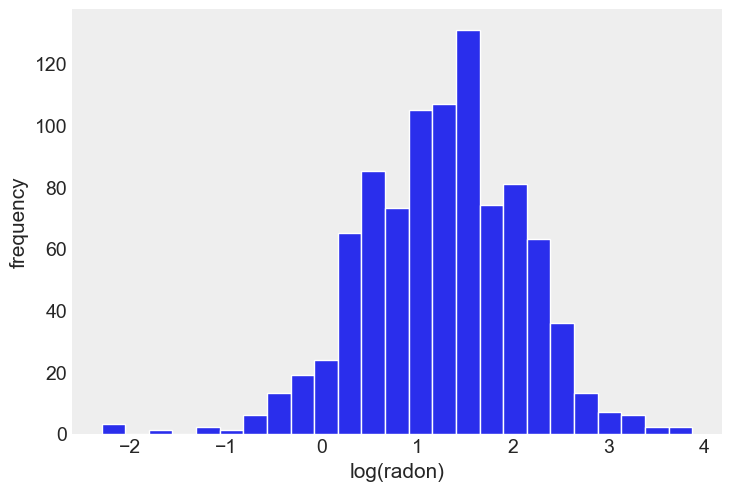

In [7]:
srrs_mn.log_radon.hist(bins=25, grid=False)
plt.xlabel("log(radon)")
plt.ylabel("frequency");

In [8]:
coords = {"county": mn_counties}

with pm.Model(coords=coords) as varying_intercept_slope:
    floor_idx = pm.MutableData("floor_idx", floor_measure, dims="obs_id")
    county_idx = pm.MutableData("county_idx", county, dims="obs_id")

    # Priors
    mu_a = pm.Normal("mu_a", mu=0.0, sigma=10.0)
    sigma_a = pm.Exponential("sigma_a", 1)

    mu_b = pm.Normal("mu_b", mu=0.0, sigma=10.0)
    sigma_b = pm.Exponential("sigma_b", 1)

    # Random intercepts
    alpha = pm.Normal("alpha", mu=mu_a, sigma=sigma_a, dims="county")
    # Random slopes
    beta = pm.Normal("beta", mu=mu_b, sigma=sigma_b, dims="county")

    # Model error
    sigma_y = pm.Exponential("sigma_y", 1)

    # Expected value
    y_hat = alpha[county_idx] + beta[county_idx] * floor_idx

    # Data likelihood
    y_like = pm.Normal("y_like", mu=y_hat, sigma=sigma_y, observed=log_radon, dims="obs_id")

F:\anaconda\envs\pymc_env\Lib\site-packages\pymc\data.py:304: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


In [9]:
with varying_intercept_slope:
    varying_intercept_slope_trace = pm.sample(tune=2000, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_a, sigma_a, mu_b, sigma_b, alpha, beta, sigma_y]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 42 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


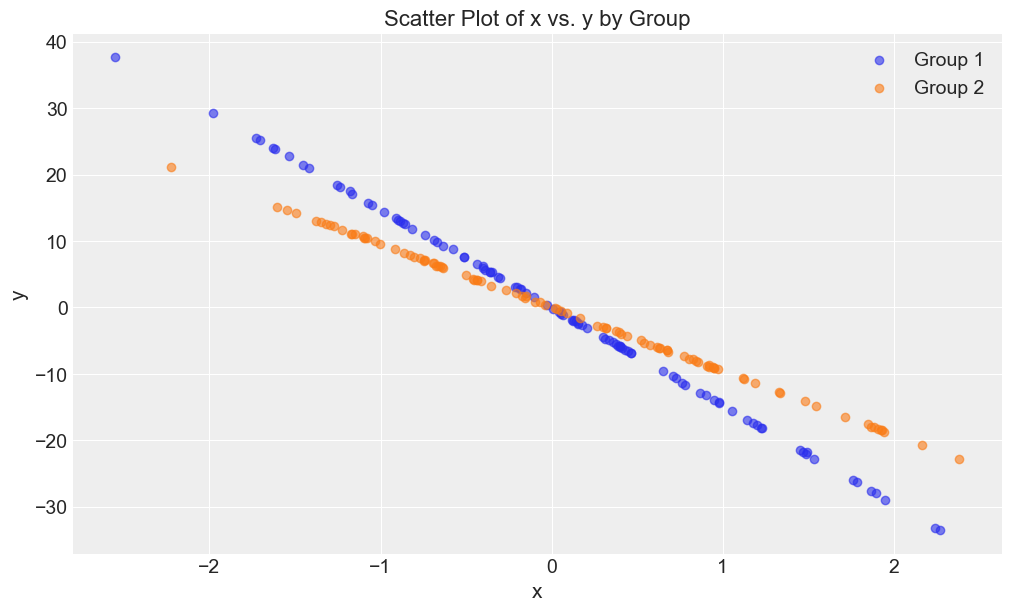

In [10]:
# Set random seed for reproducibility
np.random.seed(0)

# Number of samples and number of components
n_samples = 200
num_components = 2

# Generate the predictor variable x
x = np.random.normal(0, np.sqrt(1), n_samples)

# Initialize the response variable y
y = np.zeros(n_samples)

# Generate random betas (coefficients)
betas = np.random.normal(0, 40, num_components)

# Create group labels
groups = np.zeros(n_samples)

# Apply the different betas for every 100 samples and add random noise
for i in range(num_components):
    start_idx = i * 100
    end_idx = (i + 1) * 100
    y[start_idx:end_idx] = x[start_idx:end_idx] * betas[i] + np.random.normal(0, 0.1, 100)
    groups[start_idx:end_idx] = i

# Create a scatter plot, color-coded by group
plt.figure(figsize=(10, 6))
for i in range(num_components):
    group_idx = groups == i
    plt.scatter(x[group_idx], y[group_idx], label=f'Group {i+1}', alpha=0.6)

# Add plot labels and legend
plt.title('Scatter Plot of x vs. y by Group')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()


# Gaussian Mixture Regression with GMR

In [2]:
import numpy as np
from gmr import GMM

# Your dataset as a NumPy array of shape (n_samples, n_features):
X = np.random.randn(100, 2)

gmm = GMM(n_components=3, random_state=0)
gmm.from_samples(X)

# Estimate GMM with expectation maximization:
X_sampled = gmm.sample(100)

# Make predictions with known values for the first feature:
x1 = np.random.randn(20, 1)
x1_index = [0]
x2_predicted_mean = gmm.predict(x1_index, x1)

<>:25: SyntaxWarning: invalid escape sequence '\m'
<>:42: SyntaxWarning: invalid escape sequence '\S'
<>:43: SyntaxWarning: invalid escape sequence '\m'
<>:25: SyntaxWarning: invalid escape sequence '\m'
<>:42: SyntaxWarning: invalid escape sequence '\S'
<>:43: SyntaxWarning: invalid escape sequence '\m'
C:\Users\10191\AppData\Local\Temp\ipykernel_18556\211232875.py:25: SyntaxWarning: invalid escape sequence '\m'
  plt.title("Linear: $p(Y | X) = \mathcal{N}(\mu_{Y|X}, \Sigma_{Y|X})$")
C:\Users\10191\AppData\Local\Temp\ipykernel_18556\211232875.py:42: SyntaxWarning: invalid escape sequence '\S'
  plt.title("Mixture of Experts: $p(Y | X) = \Sigma_k \pi_{k, Y|X} "
C:\Users\10191\AppData\Local\Temp\ipykernel_18556\211232875.py:43: SyntaxWarning: invalid escape sequence '\m'
  "\mathcal{N}_{k, Y|X}$")


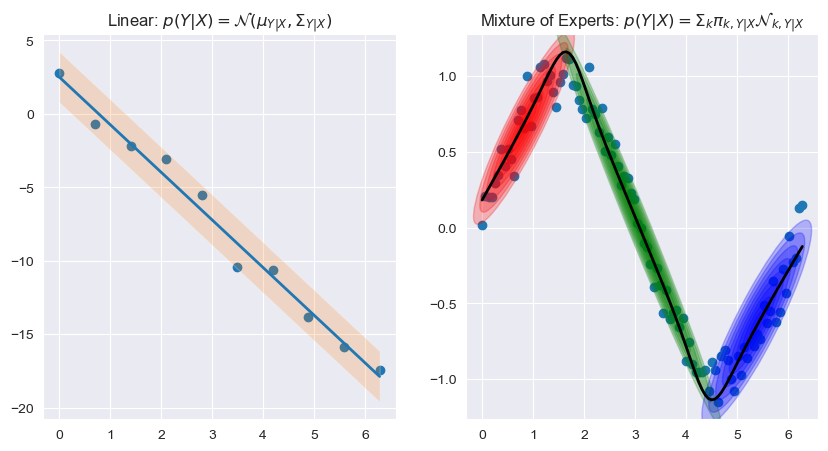

In [3]:
from sklearn.mixture import GaussianMixture
from gmr import GMM
import numpy as np
import matplotlib.pyplot as plt
from gmr.utils import check_random_state
from gmr import MVN, GMM, plot_error_ellipses


random_state = check_random_state(0)

n_samples = 10
X = np.ndarray((n_samples, 2))
X[:, 0] = np.linspace(0, 2 * np.pi, n_samples)
X[:, 1] = 1 - 3 * X[:, 0] + random_state.randn(n_samples)

mvn = MVN(random_state=0)
mvn.from_samples(X)

X_test = np.linspace(0, 2 * np.pi, 100)
mean, covariance = mvn.predict(np.array([0]), X_test[:, np.newaxis])

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Linear: $p(Y | X) = \mathcal{N}(\mu_{Y|X}, \Sigma_{Y|X})$")
plt.scatter(X[:, 0], X[:, 1])
y = mean.ravel()
s = 1.96 * np.sqrt(covariance.ravel())  # interval covers 95% of the data
plt.fill_between(X_test, y - s, y + s, alpha=0.2)
plt.plot(X_test, y, lw=2)

n_samples = 100
X = np.ndarray((n_samples, 2))
X[:, 0] = np.linspace(0, 2 * np.pi, n_samples)
X[:, 1] = np.sin(X[:, 0]) + random_state.randn(n_samples) * 0.1

gmm = GMM(n_components=3, random_state=0)
gmm.from_samples(X)
Y = gmm.predict(np.array([0]), X_test[:, np.newaxis])

plt.subplot(1, 2, 2)
plt.title("Mixture of Experts: $p(Y | X) = \Sigma_k \pi_{k, Y|X} "
          "\mathcal{N}_{k, Y|X}$")
plt.scatter(X[:, 0], X[:, 1])
plot_error_ellipses(plt.gca(), gmm, colors=["r", "g", "b"])
plt.plot(X_test, Y.ravel(), c="k", lw=2)

plt.show()

# Bayesian Gaussian Mixture Regression with PyMC3

In [2]:
import os
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt
import seaborn as sns
import xarray as xr

## Bayesian Mixtures of Linear Regression Models 
Here we define the model $Y_{ij}=X_{ij}\beta_j + \epsilon_{ij}$ 


In [3]:
RANDOM_SEED = 42
k = 2

In [41]:
# Dataset 1
df = pd.read_csv('mixture.csv')
X = df['X'].values[:, None]
Y = df['Y'].values
 # Set k to small value for testing

In [4]:
# Dataset 2
# Another example of linear regression model with two components
# Update n to 1000 for the new data generation
n = 1000
# Parameters for the two linear regression models
b = [5, 10]  # slopes
a = [0, 10]   # intercepts
n = 100       # number of samples
sigma = 0.01   # standard deviation for the noise
k=2

# Generate X values for the first 500 samples and second 500 samples separately
X1 = np.random.uniform(-10, 10, size=(100, 1))
X2 = np.random.uniform(-10, 10, size=(100, 1))

# Generate noise
e1 = np.random.normal(0, sigma, size=(100, 1))
e2 = np.random.normal(0, sigma, size=(100, 1))

# Generate Y values based on two different linear regressions
Y1 = b[0] * X1 + a[0] + e1
Y2 = b[1] * X2 + a[1] + e2
#Y1 =  b[0] + e1
#Y2 =  b[1] + e2

# Combine the data into a single DataFrame
X = np.vstack([X1, X2])
Y = np.vstack([Y1, Y2]).ravel()

In [9]:
# Dataset 3
n_samples = 100
random_state = np.random.RandomState(42)
X = np.ndarray((n_samples, 2))
X = np.linspace(0, 2 * np.pi, n_samples)
Y = np.sin(X) + random_state.randn(n_samples) * 0.1
k = 3


The model is defined as follows:
$$\pi_i \sim Dirichlet(k)$$
$$\alpha_i \sim Normal(0, 100)$$
$$\beta_i \sim Normal(0, 100)$$
$$\sigma_i \sim HalfCauchy(5)$$

$$\mu_{i} = \alpha_{i} + \beta_{i} X$$
$$Y|X, \alpha, \beta, \sigma, \pi \sim \Sigma_{i}^{k}\pi_i Normal(\mu_i, \sigma_i)$$

In [10]:
#With dirichlet distribution
with pm.Model() as Mixture_regression1:
    # Priors for weight parameter
    π = pm.Dirichlet('π', np.array([1]*k), initval=np.ones(k)/k) # Component weights
    
    # Priors for unknown model parameters
    α = pm.Normal('α', mu=0, sigma=100, shape=(1, k)) #Intercept
    β = pm.Normal('β', mu=0, sigma=100, shape=(1, k))
    σ  = pm.HalfCauchy('σ', 5, shape=k)  #Noise
    
    mu = α + β*X
        
    likelihood = pm.NormalMixture('likelihood', π, mu, sigma=σ, observed=Y)
    trace = pm.sample(tune=2500,
            init="advi",
            target_accept=0.975,
            random_seed=RANDOM_SEED,)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [π, α, β, σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 85 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


The model is defined as follows:
$$ \alpha \sim Gamma(1,5)$$
$$ \beta \sim Beta(1, \alpha)$$
$$ \pi_i \sim \beta_i\Pi_{j=1}^{i-1}(1-\beta_j)$$

$$\mu_{i} = \alpha_{i} + \beta_{i} X$$
$$\sigma_i \sim HalfCauchy(1)$$
$$Y|X, \alpha, \beta, \sigma, \pi \sim \Sigma_{i}^{k}\pi_i Normal(\mu_i, \sigma_i)$$

In [6]:
def stick_breaking(beta):
    portion_remaining = pt.concatenate([[1], pt.extra_ops.cumprod(1 - beta)[:-1]])
    return beta * portion_remaining

In [15]:
def re_prameterize(beta):
    return beta / beta.sum()

In [16]:
#Dirichlet Process Gaussian Mixture Model
#still debugging
N = Y.shape[0]
with pm.Model(coords={"component": np.arange(k),"obs_id": np.arange(N)}) as Mixture_regression2:
    # Priors for weight parameter
    alpha = pm.Gamma("alpha", 1.0, 5.0)
    beta = pm.Beta("beta", 1.0, alpha, dims="component") # Generate beta values
    π = pm.Deterministic("π", stick_breaking(beta), dims="component")  # Component weights
    π1 = pm.Deterministic("π1", re_prameterize(π), dims="component")  # Component weights
    
    # Priors for unknown model parameters
    α = pm.Normal('α', mu=0, sigma=100, shape=(1, k)) #Intercept
    β = pm.Normal('β', mu=0, sigma=100, shape=(1, k))
    
    σ  = pm.HalfCauchy('σ', 1, shape=k)  #Noise
    
    mu = α + β*X
    #mu = α    
    likelihood = pm.NormalMixture('likelihood', π1, mu, sigma=σ, observed=Y)
    trace = pm.sample(
            tune=2500,
            init="advi",
            target_accept=0.975,
            random_seed=RANDOM_SEED,
        )

Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Output()

Convergence achieved at 84800
Interrupted at 84,799 [42%]: Average Loss = 5,985.9
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, α, β, σ]


Output()

Sampling 4 chains for 2_500 tune and 1_000 draw iterations (10_000 + 4_000 draws total) took 51 seconds.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [10]:
Mixture_regression1.debug(verbose=True)

point={'alpha_log__': array(-1.6094379), 'beta_logodds__': array([1.6094379, 1.6094379]), 'α': array([[0., 0.]]), 'β': array([[0., 0.]]), 'σ_log__': array([0., 0.])}

The variable likelihood has the following parameters:
0: Mul [id A] <Vector(float64, shape=(?,))> 'π'
 ├─ Sigmoid [id B] <Vector(float64, shape=(?,))> 'beta'
 │  └─ beta_logodds__ [id C] <Vector(float64, shape=(?,))>
 └─ Join [id D] <Vector(float64, shape=(?,))>
    ├─ 0 [id E] <Scalar(int8, shape=())>
    ├─ [1] [id F] <Vector(int32, shape=(1,))>
    └─ Subtensor{:stop} [id G] <Vector(float64, shape=(?,))>
       ├─ CumOp{None, mul} [id H] <Vector(float64, shape=(?,))>
       │  └─ Sub [id I] <Vector(float64, shape=(?,))>
       │     ├─ [1.] [id J] <Vector(float64, shape=(1,))>
       │     └─ Sigmoid [id B] <Vector(float64, shape=(?,))> 'beta'
       │        └─ ···
       └─ -1 [id K] <int64>
1: normal_rv{"(),()->()"}.1 [id L] <Matrix(float64, shape=(200, 2))>
 ├─ RNG(<Generator(PCG64) at 0x21DB5BB1380>) [id M] <Rando

array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'α'}>, <Axes: title={'center': 'α'}>],
       [<Axes: title={'center': 'β'}>, <Axes: title={'center': 'β'}>],
       [<Axes: title={'center': 'π'}>, <Axes: title={'center': 'π'}>],
       [<Axes: title={'center': 'π1'}>, <Axes: title={'center': 'π1'}>],
       [<Axes: title={'center': 'σ'}>, <Axes: title={'center': 'σ'}>]],
      dtype=object)

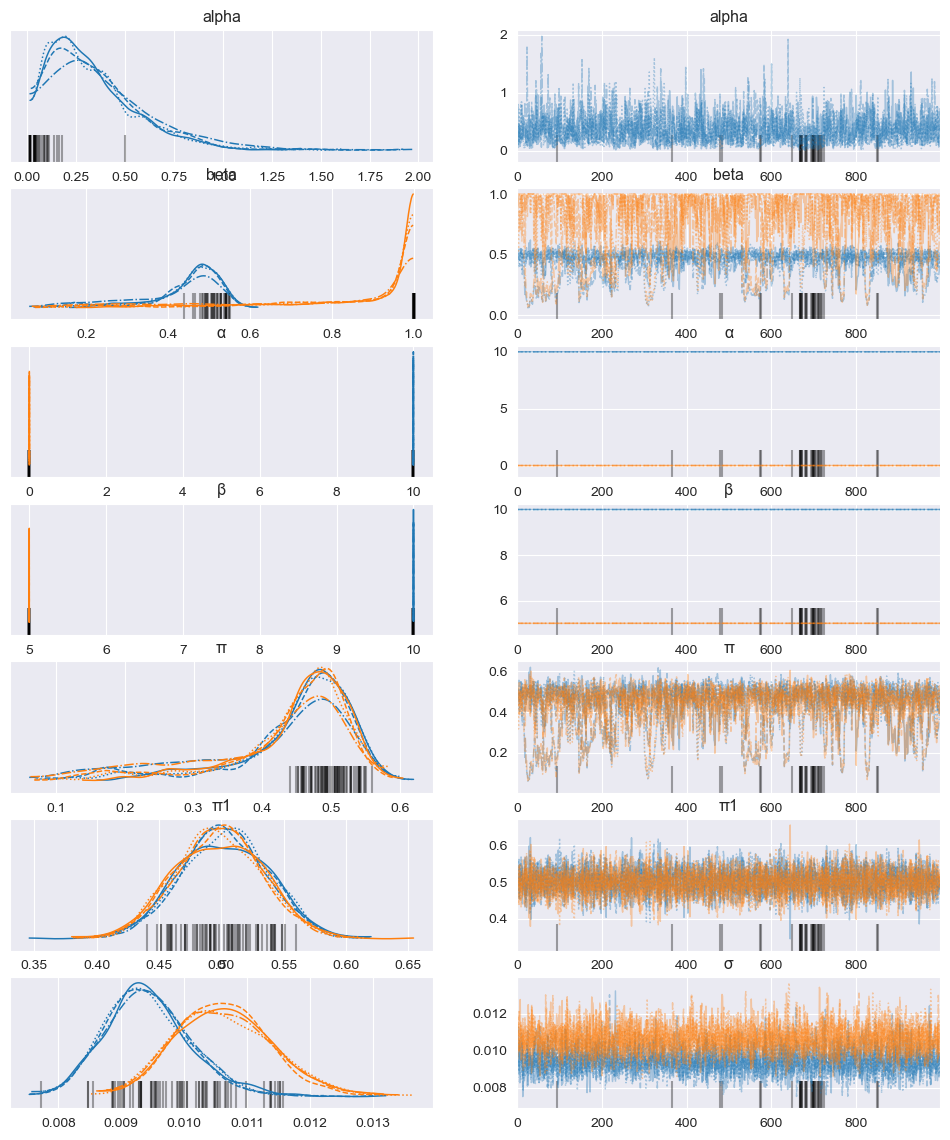

In [17]:
az.plot_trace(trace) 

In [18]:
with Mixture_regression1:
    posterior_predictive = pm.sample_posterior_predictive(trace, random_seed=RANDOM_SEED)

Sampling: [likelihood]


Output()

In [19]:
summary = az.summary(trace, var_names=['α', 'β', 'π', 'σ'])
print(summary)

           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
α[0, 0]  10.001  0.001   9.999   10.002      0.000    0.000    6157.0   
α[0, 1]  -0.000  0.001  -0.002    0.001      0.000    0.000    3923.0   
β[0, 0]  10.000  0.000  10.000   10.000      0.000    0.000    5994.0   
β[0, 1]   5.000  0.000   5.000    5.001      0.000    0.000    4117.0   
π[0]      0.439  0.100   0.215    0.579      0.011    0.008     158.0   
π[1]      0.435  0.098   0.213    0.570      0.011    0.008     154.0   
σ[0]      0.009  0.001   0.008    0.011      0.000    0.000    4060.0   
σ[1]      0.011  0.001   0.009    0.012      0.000    0.000    4070.0   

         ess_tail  r_hat  
α[0, 0]    3123.0   1.00  
α[0, 1]    2886.0   1.00  
β[0, 0]    2977.0   1.00  
β[0, 1]    2561.0   1.00  
π[0]        113.0   1.03  
π[1]        131.0   1.03  
σ[0]       2622.0   1.00  
σ[1]       2729.0   1.00  


array([[<Axes: title={'center': 'α\n0, 0'}>,
        <Axes: title={'center': 'α\n0, 1'}>,
        <Axes: title={'center': 'β\n0, 0'}>,
        <Axes: title={'center': 'β\n0, 1'}>],
       [<Axes: title={'center': 'σ\n0'}>,
        <Axes: title={'center': 'σ\n1'}>,
        <Axes: title={'center': 'π\n0'}>,
        <Axes: title={'center': 'π\n1'}>]], dtype=object)

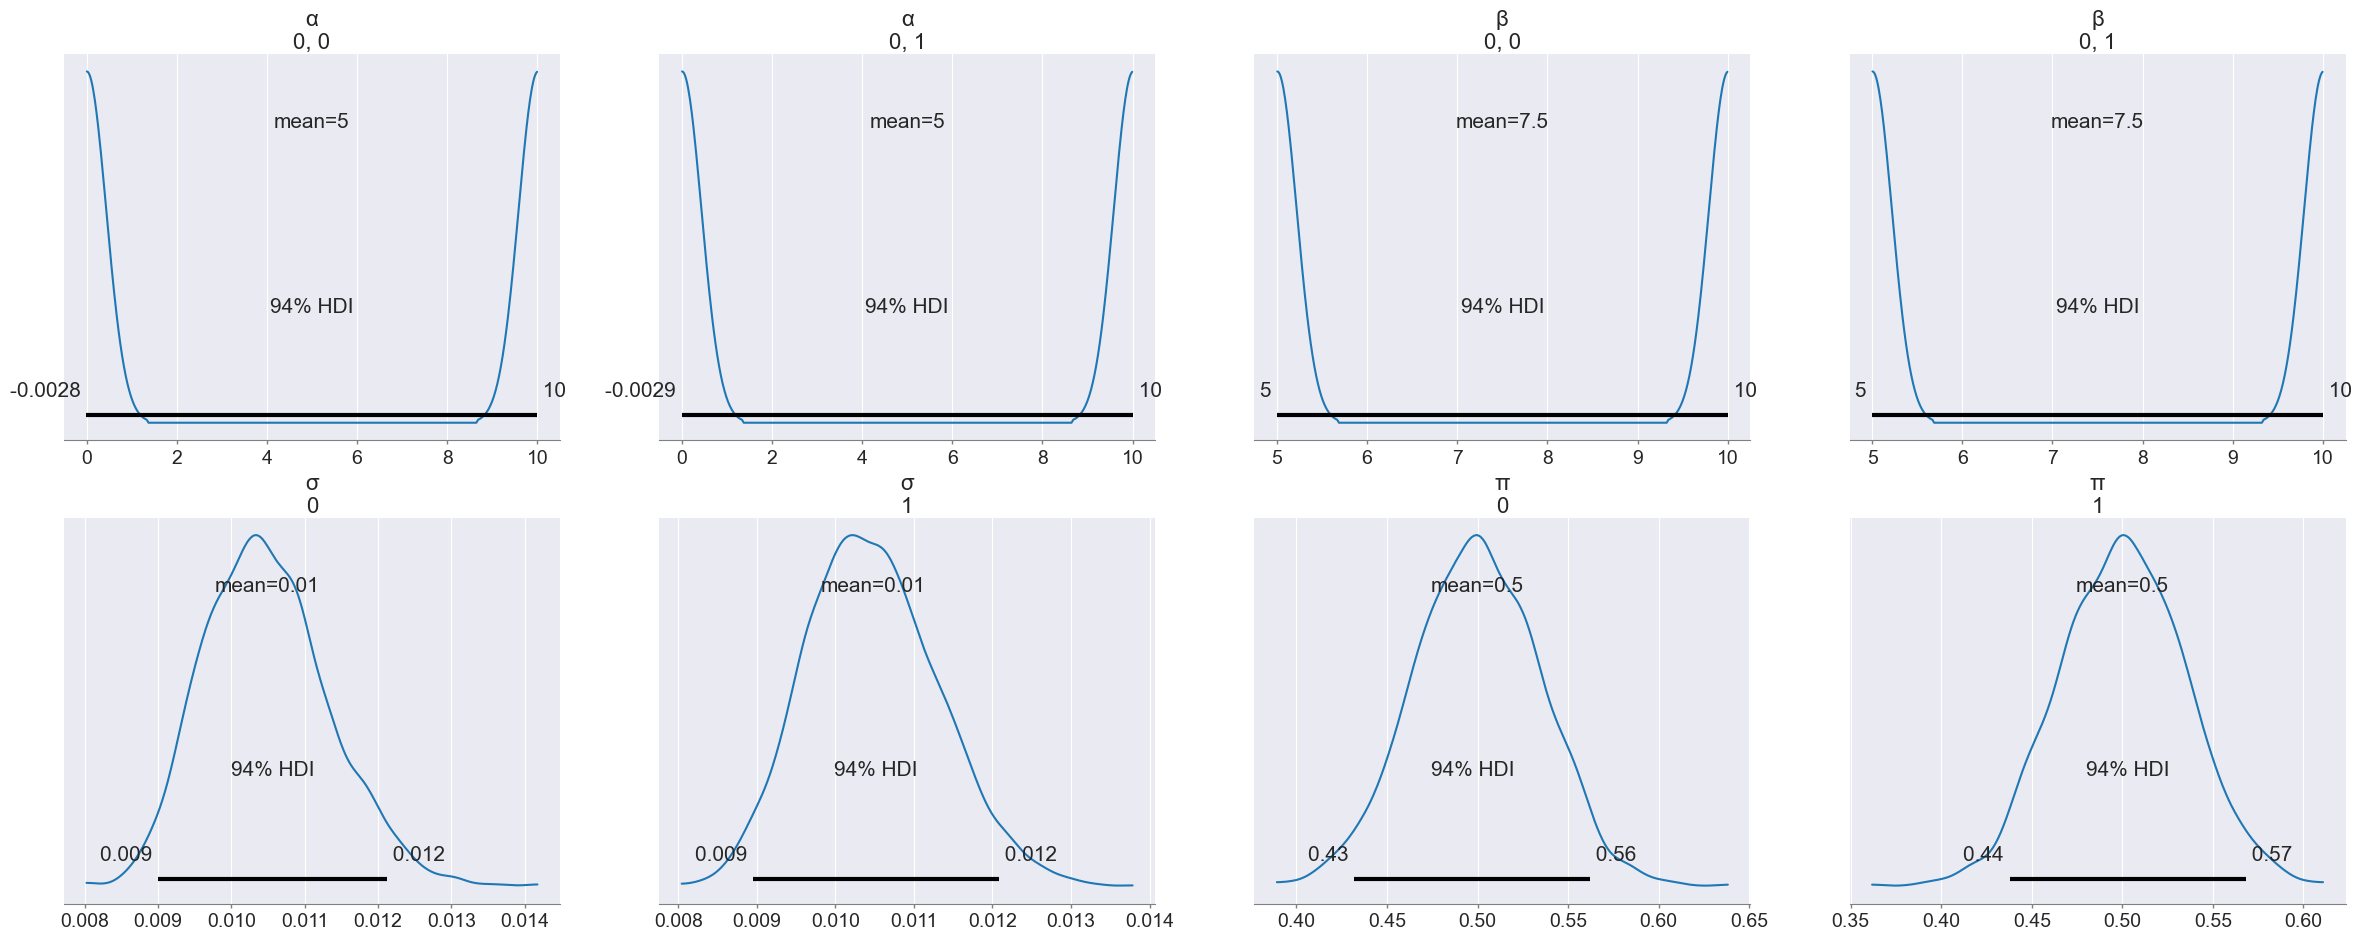

In [9]:
az.plot_posterior(trace, var_names=["α", "β", "σ", "π"])


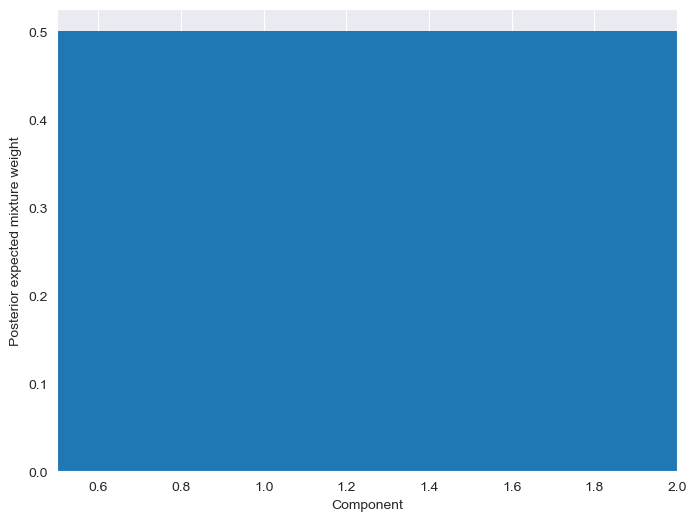

In [14]:
fig, ax = plt.subplots(figsize=(8, 6))

plot_w = np.arange(k) + 1

ax.bar(plot_w - 0.5, trace.posterior["π"].mean(("chain", "draw")), width=1.0, lw=0)

ax.set_xlim(0.5, k)
ax.set_xlabel("Component")

ax.set_ylabel("Posterior expected mixture weight");

In [16]:
import xarray as xr
import scipy as sp

In [77]:
# x_plot from xmin to xmax
x_plot = np.linspace(X.min()-5, X.max()+5, 1000)
a_post = trace.posterior["α"].values
b_post = trace.posterior["β"].values
sigma_post = trace.posterior["σ"].values

mu = a_post+b_post*x_plot[:, None]

In [78]:
mu.shape

(4, 1000, 1000, 2)

In [79]:
post_pdf_contribs1 = xr.apply_ufunc(
    sp.stats.norm.pdf,
    x_plot,
    mu,
    sigma_post,
)

post_pdfs = (trace.posterior["π"] * post_pdf_contribs1).sum(dim=("component"))

post_pdf_quantiles = post_pdfs.quantile([0.1, 0.9], dim=("chain", "draw"))


ValueError: operands could not be broadcast together with shapes (1000,) (4,1000,1000,2) 

In [81]:
# Ensure x_plot is compatible for broadcasting
# x_plot should be (1000, 1) to match (chain, draw, parameter)
x_plot_reshaped = x_plot[:, None, None]

# Calculate mu with proper broadcasting
# a_post (chain, draw, parameter) and b_post (chain, draw, parameter)
mu = a_post + b_post * x_plot_reshaped  # This will expand to (chain, draw, parameter, 1000)

# Calculate the PDF using xarray and scipy.stats.norm.pdf
# sp.stats.norm.pdf needs the dimensions (mu, scale) where mu and scale match
import scipy as sp
import xarray as xr

post_pdf_contribs1 = xr.apply_ufunc(
    sp.stats.norm.pdf,
    x_plot_reshaped,  # Now properly reshaped for broadcasting
    mu,  # (chain, draw, parameter, 1000)
    sigma_post[:, :, :, None],  # Broadcast sigma_post similarly (chain, draw, parameter, 1)
    input_core_dims=[['x'], ['component', 'x'], ['component', 'x']],  # Adjust core dimensions
    vectorize=True
)
w_expanded = trace.posterior["π"].values[:, :, :, None]

post_pdfs = (w_expanded * post_pdf_contribs1)